# Astro Query  ReACT Agent

#### Using Langchain Agent Library

![Astro langchain](../images/astro_langchain.png)

In [1]:
%pip install langchain-openai langchain pyvo astroquery astropy Pillow pandasai python-dotenv pydantic==1.10.8


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Import Libraries

In [1]:
import os
import re
import matplotlib.pyplot as plt
import dotenv
dotenv.load_dotenv()

import tiktoken

from astropy import coordinates as coords, units as u
from astroquery.simbad import Simbad
from astroquery.skyview import SkyView
from astropy.coordinates import SkyCoord
from astroquery.ipac.nexsci.nasa_exoplanet_archive import NasaExoplanetArchive
from astroquery import nasa_ads as na
na.ADS.TOKEN = os.getenv("ADS_API_KEY")

from langchain.agents import Tool
from langchain import LLMChain, PromptTemplate
from typing import List, Union
from langchain.agents import (
    AgentExecutor,
    AgentOutputParser,
    LLMSingleActionAgent,
)
from langchain.chat_models import AzureChatOpenAI, ChatOpenAI
from langchain.prompts import BaseChatPromptTemplate
from langchain.schema import AgentAction, AgentFinish, HumanMessage


import pprint
pprint = pprint.PrettyPrinter(indent=4, width=120, depth=2)

## ReACT Agent

The ReACT agent model refers to a framework that integrates the reasoning capabilities of large language models (LLMs) with the ability to take actionable steps, creating a more sophisticated system that can understand and process information, evaluate situations, take appropriate actions, communicate responses, and track ongoing situations.

The main components of the ReACT agent are:
- Chain of Thought - ReACT Prompt
- Tools for LLMs to use - ReACT Actions
- Helper functions to control and route the Agent's actions - ReACT Controllers

## Prompts

In [2]:
#react template
astro_template = """
Decode the following Astronomy query using given tools as best you can.
The query will involve a search for astronomical objects in a specific region of the sky, drawing the region, or finding data about a specific astronomical object using bibcode.
You have access to the following tools:

{tools}

Use the following format:

Query: the input question you must answer
Thought: you should always think about what to do. If the Query is not a valid astromonical data query, Provide Final Answer asking the user to provide the correct query. Any other question to the user will need to be given as Final Answer.
Action: the action to take, should be one of [{tool_names}].
Action Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Final Answer: I now have finished 

Begin Loop:

Query: {input}
{agent_scratchpad}"""


datetime_template = """
            convert time string: {datetime} into start and end datetime formatted as: 'temporal[]=yyyy-MM-ddTHH:mm:ssZ,yyyy-MM-ddTHH:mm:ssZ'
            """


## Tools

External Tools and servides used:

- Astroquery helper
- simbad
- SkyView API for image retrieval
- ADS for documentation of astronomical objects
- NASA Exoplanet Archive for exoplanet related questions

In [3]:
def get_skycoords_from_text(text: str) -> str:
    """Converts a string representing a celestial object to its coordinates.

    Args:
        text (str): The string to convert to coordinates.

    Returns:
        str: The coordinates of the celestial object.
    """
    try:
        coord = SkyCoord.from_name(text)
        return coord.to_string('hmsdms')
    except Exception as e:
        return f"Invalid input:, {e}"

def query_simbad_object(coord: str, radius: str=2*u.arcminute) -> str:
    """Query the SIMBAD database for an astronomical object.

    Args:
        RA (str): The right ascension of the object.
        DEC (str): The declination of the object.
        radius (str): The radius of the search area. default is 2*u.arcminute.
        object_type (str): The type of object to search for.

    Returns:
        str: The result of the query.
    """
    simbad = Simbad()
    RA, DEC = coord.split(' ')
    try:
        result = simbad.query_region(
            coords.SkyCoord(RA, DEC, frame='icrs'),
            radius=radius,
        )
        # print the first 10 results
        result.pprint(max_width=100)
        return result
    except Exception as e:
        return f"Invalid input:, {e}"

def draw_image_from_coords(coord: str, radius: str=2*u.arcminute) -> str:
    """Draw an image of the sky around a given set of coordinates.

    Args:
        RA (str): The right ascension of the object.
        DEC (str): The declination of the object.
        radius (str): The radius of the search area. default is 2*u.arcminute.

    Returns:
        str: The path to the image file.
    """
    try:
        ra, dec = coord.split(' ')
        position = SkyCoord(ra, dec, frame='icrs', unit=(u.hourangle, u.deg))

        # Fetch the image
        images = SkyView.get_images(position=position, survey='DSS', radius=0.1 * u.deg)

        image_data = images[0][0].data

        plt.figure(figsize=(8, 8))
        plt.imshow(image_data, cmap='gray', origin='lower')
        plt.xlabel('RA')
        plt.ylabel('DEC')
        plt.title('Image')
        plt.colorbar(label='Flux')
        plt.show()

        return "Image Plotted"
    except Exception as e:
        return f"Invalid input:, {e}"

def search_docs_with_bibcode(bibcode: str) -> str:
    """Search for documents with a given bibcode.

    Args:
        bibcode (str): The bibcode to search for.

    Returns:
        str: The result of the search.
    """
    try:
        results = na.ADS.query_simple(bibcode)
        
        return results[-1]
    except Exception as e:
        return f"Invalid input:, {e}"

def get_bibcode_from_coords(coord: str, radius: str=2*u.arcminute) -> str:
    """Get the bibcode for a given set of coordinates.

    Args:
        RA (str): The right ascension of the object.
        DEC (str): The declination of the object.
        radius (str): The radius of the search area. default is 2*u.arcminute.

    Returns:
        str: The bibcode of the object.
    """
    try:
        ra, dec = coord.split(' ')
        position = SkyCoord(ra, dec, frame='icrs', unit=(u.hourangle, u.deg))

        result = Simbad.query_region(position, radius=radius)
        bibcode = result['COO_BIBCODE'][0]
        return bibcode
    
    except Exception as e:
        return f"Invalid input:, {e}"

def query_nasa_exoplanet_archive_db(name: str) -> str:
    """Query the NASA Exoplanet Archive database for an exoplanet.

    Args:
        name (str): The name of the exoplanet.

    Returns:
        str: The result of the query.
    """
    try:
        result = NasaExoplanetArchive.query_object(name)
        return result
    except Exception as e:
        return f"Invalid input:, {e}"

def num_tokens_from_string(string: str, model_name: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.encoding_for_model(model_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens



In [4]:
## pandas AI functions
import pandas as pd
from pandasai.connectors import PandasConnector
from pandasai import SmartDataframe
from pandasai.llm import BambooLLM

def save_nasa_exoplanet_archive_data_to_file(planet_name: str) -> str:
    
    result = NasaExoplanetArchive.query_object(planet_name)
    
    # os.environ["PANDASAI_API_KEY"] = ""

    df = result.to_pandas()
    # filter columns based on these values
    column_filters = ["pl_name",
    "pl_letter",
    "hostname",
    "hd_name",
    "hip_name",
    "tic_id",
    "gaia_id",
    "pl_refname",
    "sy_refname",
    "disc_pubdate",
    "disc_year",
    "discoverymethod",
    "disc_locale",
    "disc_facility",
    "disc_instrument",
    "disc_telescope"]

    df = df[column_filters]
    df.to_csv("temp.csv")

    return "Data saved to temp.csv"
    
def read_exoplanet_data_from_file_and_query(query: str) -> str:
    
    df = pd.read_csv("temp.csv")
    field_descriptions = { 
        "pl_name": "The name of the planet",
        "pl_letter": "The letter associated with the planet",
        "hostname": "The name of the host star",
        "hd_name": "The HD name of the host star",
        "hip_name": "The HIP name of the host star",
        "tic_id": "The TIC ID of the host star",
        "gaia_id": "The Gaia ID of the host star",
        "pl_refname": "The reference name and document of the planet",
        "sy_refname": "The reference name and document of the system",
        "disc_pubdate": "The publication date of the discovery",
        "disc_year": "The year of the discovery",
        "discoverymethod": "The method of discovery",
        "disc_locale": "The location of the discovery",
        "disc_facility": "The facility of the discovery",
        "disc_instrument": "The instrument of the discovery",
        "disc_telescope": "The telescope of the discovery",
    }
    connector = PandasConnector({"original_df": df}, field_descriptions=field_descriptions)
    llm = BambooLLM()
    return SmartDataframe(connector, config={"llm": llm}).chat(query)

## Langchain

Langchain is a library that provides a set of tools to interact with language models, such as GPT-3, and to build agents that can understand and process information, evaluate situations, take appropriate actions, communicate responses, and track ongoing situations. Below is a simple example of how to use the library to implement a ReACT agent.

Components used:
CustomPromptTemplate - ReACT Prompt class
CustomOutputParser - ReACT Output controller class for routing LLM actions
Agent - ReACT Agent class

In [5]:
class CustomPromptTemplate(BaseChatPromptTemplate):
    """
    This is a custom prompt template that uses the `cmr_template` from `prompts.py`
    """

    template: str
    tools: List[Tool]

    def format_messages(self, **kwargs) -> str:
        # Get the intermediate steps (AgentAction, Observation tuples)
        # Format them in a particular way
        intermediate_steps = kwargs.pop("intermediate_steps")
        thoughts = ""
        for action, observation in intermediate_steps:
            thoughts += action.log
            thoughts += f"\nObservation: {observation}\nThought: "
        kwargs["agent_scratchpad"] = thoughts
        # Create a tools variable from the list of tools provided
        kwargs["tools"] = "\n".join(
            [f"{tool.name}: {tool.description}" for tool in self.tools]
        )
        # Create a list of tool names for the tools provided
        kwargs["tool_names"] = ", ".join([tool.name for tool in self.tools])
        formatted = self.template.format(**kwargs)
        return [HumanMessage(content=formatted)]


class CustomOutputParser(AgentOutputParser):
    """
    This is a custom output parser that parses the output of the LLM agent
    """

    def parse(self, llm_output: str) -> Union[AgentAction, AgentFinish]:
        # Check if agent should finish
        if "Final Answer:" in llm_output:
            return AgentFinish(
                return_values={"output": llm_output.split("Final Answer:")[-1].strip()},
                log=llm_output,
            )
        
        regex = r"Action\s*\d*\s*:(.*?)\nAction\s*\d*\s*Input\s*\d*\s*:[\s]*(.*)"
        match = re.search(regex, llm_output, re.DOTALL)
        if not match:
            raise ValueError(f"Could not parse LLM output: `{llm_output}`")
        action = match.group(1).strip()
        action_input = match.group(2)
        # Return the action and action input
        return AgentAction(
            tool=action, tool_input=action_input.strip(" ").strip('"'), log=llm_output
        )


class AstroQueryAgent:
    """
    This is a custom agent that uses the `CustomPromptTemplate` and `CustomOutputParser`
    """

    def __init__(self):
        self.create_tools()
        self.tool_names = [tool.name for tool in self.tools]
        self.prompt = CustomPromptTemplate(
            template=astro_template,
            tools=self.tools,
            # This omits the `agent_scratchpad`, `tools`, and `tool_names` variables because those are generated dynamically
            # This includes the `intermediate_steps` variable because that is needed
            input_variables=["input", "intermediate_steps"],
        )
        self.output_parser = CustomOutputParser()
        self.llm_chain = LLMChain(
            # llm=ChatOpenAI(model_name="gpt-4-1106-preview", temperature=0),
            llm=AzureChatOpenAI(model_name="gpt-4-1106-preview", temperature=0),
            prompt=self.prompt,
        )
        self.create_agent()

    def create_tools(self):
        """create tools for the agent"""
        self.tools = [
            Tool(
                name="query_simbad_object",
                description="Get simbad object from RA and DEC",
                func=query_simbad_object,
            ),
            Tool(
                name="get_skycoords_from_text",
                description="Get sky coordinates from text of a celestial object",
                func=get_skycoords_from_text,
            ),
            Tool(
                name="draw_image_from_coords",
                description="Draw an image of the sky around a given set of coordinates",
                func=draw_image_from_coords,
            ),
            Tool(
                name="search_docs_with_bibcode",
                description="Search for documents with a given bibcode",
                func=search_docs_with_bibcode,
            ),
            Tool(
                name="get_bibcode_from_coords",
                description="Get the bibcode for a given set of coordinates",
                func=get_bibcode_from_coords,
            ),
            Tool(
                name="save_nasa_exoplanet_archive_data_to_file",
                description="search for and save exoplanet data to file. Always use this tool for exoplanet data queries. Always follow up with read_exoplanet_data_from_file_and_query",
                func=save_nasa_exoplanet_archive_data_to_file,
            ),            
            Tool(
                name="read_exoplanet_data_from_file_and_query",
                description="Read exoplanet data from file and query.",
                func=read_exoplanet_data_from_file_and_query,
            ),
        ]

    def create_agent(self):
        self.agent = LLMSingleActionAgent(
            llm_chain=self.llm_chain,
            output_parser=self.output_parser,
            stop=["\nObservation:"],
            allowed_tools=self.tool_names,
        )
        self.agent_executor = AgentExecutor.from_agent_and_tools(
            agent=self.agent, tools=self.tools, verbose=True
        )

    def run_query(self, input_text: str):
        return self.agent_executor.run(input_text)

query_agent = AstroQueryAgent()

/Users/mramasub/work/workshop-usecases-llm/.venv/lib/python3.12/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.chat_models.azure_openai.AzureChatOpenAI` was deprecated in langchain-community 0.0.10 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import AzureChatOpenAI`.
  warn_deprecated(
/Users/mramasub/work/workshop-usecases-llm/.venv/lib/python3.12/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The class `langchain.agents.agent.LLMSingleActionAgent` was deprecated in langchain 0.1.0 and will be removed in 0.2.0. Use Use new agent constructor methods like create_react_agent, create_json_agent, create_structured_chat_agent, etc. instead.
  warn_deprecated(


In [6]:
query= "what is the discovery method of K2 18 b?"
print(
    query_agent.run_query(query)
)


/Users/mramasub/work/workshop-usecases-llm/.venv/lib/python3.12/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(




> Entering new AgentExecutor chain...
Thought: The query is asking for specific data about an exoplanet, K2-18 b. To find this information, I should use the tools provided to search for and save exoplanet data to a file, and then query that file for the discovery method of K2-18 b.

Action: save_nasa_exoplanet_archive_data_to_file
Action Input: K2-18 b

Observation:Data saved to temp.csv
Now that the data is saved, I need to read the file and query it for the discovery method of K2-18 b.

Action: read_exoplanet_data_from_file_and_query
Action Input: Discovery method of K2-18 b

Observation:The discovery method of K2-18 b is: Transit
Final Answer: The discovery method of K2-18 b is Transit.

> Finished chain.
The discovery method of K2-18 b is Transit.


In [7]:
query= "provide documentation for K2-18"
print(
    query_agent.run_query(query)
)




> Entering new AgentExecutor chain...
Thought: To provide documentation for K2-18, I need to find documents related to it. The best way to do this is by using its bibcode, which is a unique identifier for literature in astronomy and astrophysics.

Action: get_skycoords_from_text
Action Input: K2-18

Observation:11h30m14.517744s +07d35m18.255336s
Now that I have the sky coordinates for K2-18, the next step is to get the bibcode associated with these coordinates to find the relevant documentation.

Action: get_bibcode_from_coords
Action Input: 11h30m14.517744s +07d35m18.255336s

Observation:2020yCat.1350....0G
With the bibcode obtained, I can now search for documents related to K2-18 using this identifier.

Action: search_docs_with_bibcode
Action Input: 2020yCat.1350....0G

Observation:      bibcode                                    title                                     author       aff            pub             volume  pubdate    page                  citation                  c



> Entering new AgentExecutor chain...
Thought: The query is asking for an image of the Crab Nebula, which is not a galaxy but a supernova remnant. First, I need to get the sky coordinates of the Crab Nebula to draw an image of the sky around it.

Action: get_skycoords_from_text
Action Input: Crab Nebula

Observation:05h34m30.888s +22d00m52.92s
Now that I have the coordinates of the Crab Nebula, I can use them to draw an image of the sky around these coordinates.

Action: draw_image_from_coords
Action Input: 05h34m30.888s +22d00m52.92s

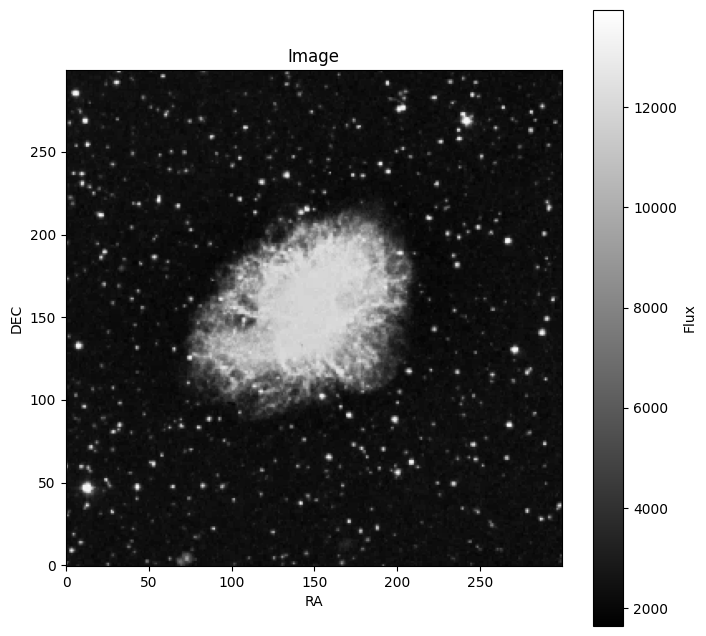



Observation:Image Plotted
The image of the Crab Nebula has been successfully plotted using the provided coordinates.

Final Answer: I now have finished drawing the image of the Crab Nebula.

> Finished chain.
I now have finished drawing the image of the Crab Nebula.


In [8]:
query= "get me image of crab nebula galaxy"
print(
    query_agent.run_query(query)
)


In [10]:
query= "What is osmosis?"
print(
    query_agent.run_query(query)
)



> Entering new AgentExecutor chain...
Thought: The query "What is osmosis?" is not a valid astronomical data query. It is a question related to biology or chemistry, specifically about the movement of solvent molecules through a semipermeable membrane. Therefore, I cannot proceed with any of the given tools to answer this question.

Final Answer: Please provide a correct astronomical data query.

> Finished chain.
Please provide a correct astronomical data query.
